In [1]:
!python -V

Python 3.11.6


In [2]:
import platform, sys, os

print("Python  :", platform.python_version())  # sys.version
print("Actv Env:", os.getenv('CONDA_DEFAULT_ENV', 'Not Found Conda Env'))
print("Platform:", platform.system())  # platform.platform()

Python  : 3.11.6
Actv Env: Not Found Conda Env
Platform: Linux


In [3]:
import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
# from statistics import mode
# from scipy.stats import mode  ## only numeric
# import scipy.stats as stats

import os
import sys
import click
import pickle
# import argparse
# import requests
# import urllib.request
from glob import glob

# from tqdm import tqdm           # console-based
# from tqdm.notebook import tqdm  # jupyter-based
from tqdm.auto import tqdm        # automatically selects
tqdm._instances.clear()
tqdm.pandas()

import mlflow
import joblib

## memory management performs garbage collection 
import gc; gc.collect()

64

In [4]:
## Create a new directory for storing data
os.makedirs('./data', exist_ok=True)
os.makedirs('./output', exist_ok=True)
os.makedirs('./model', exist_ok=True)
os.makedirs('./pycode', exist_ok=True)
# os.makedirs('tests', exist_ok=True)
# os.makedirs('integration_test', exist_ok=True)
# os.makedirs('utils', exist_ok=True)
## Get the current working directory
# current_dir = os.getcwd()

In [5]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: mlflow, scikit-plot, scikit-plots


## Ingest Data [wget](https://linuxways.net/centos/linux-wget-command-with-examples/) or [curl](https://daniel.haxx.se/blog/2020/09/10/store-the-curl-output-over-there/)

```sh
## Download NYC taxi trip data
!pip install pyarrow fastparquet
!curl -s -O --create-dirs --output-dir "./data" "https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2019-09.csv.gz"
!curl -s -O --create-dirs --output-dir "./data" "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2019-09.parquet"
!wget -q -N -P "./data" "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"
```

In [6]:
!wget -q -N -P "./data" "https://s3.amazonaws.com/tripdata/JC-202402-citibike-tripdata.csv.zip"
!wget -q -N -P "./data" "https://s3.amazonaws.com/tripdata/JC-202403-citibike-tripdata.csv.zip"
!wget -q -N -P "./data" "https://s3.amazonaws.com/tripdata/JC-202404-citibike-tripdata.csv.zip"

In [7]:
import zipfile
import os
import io

# Define the paths
zip_file_path  = 'data/JC-20240{}-citibike-tripdata.csv.zip'
extract_path   = 'data/'
for i in range(2,5):
    # Open the ZIP file and extract its contents
    with zipfile.ZipFile(zip_file_path.format(i), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Verify the extraction
extracted_files = os.listdir(extract_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['JC-202404-citibike-tripdata.csv', 'JC-202402-citibike-tripdata.csv.zip', 'JC-202404-citibike-tripdata.parquet', 'JC-202402-citibike-tripdata.csv', '__MACOSX', '.ipynb_checkpoints', 'JC-202403-citibike-tripdata.csv.zip', 'JC-202404-citibike-tripdata.csv.zip', 'JC-202403-citibike-tripdata.csv', 'JC-202402-citibike-tripdata.parquet']


In [8]:
glob(f'./data/*.csv')

['./data/JC-202404-citibike-tripdata.csv',
 './data/JC-202402-citibike-tripdata.csv',
 './data/JC-202403-citibike-tripdata.csv']

In [9]:
df_raw = pd.read_csv('./data/JC-202402-citibike-tripdata.csv', sep=",")

## Save the data to a parquet file
df_raw.to_parquet('data/JC-202402-citibike-tripdata.parquet', index=False)
df_raw = pd.read_parquet('data/JC-202402-citibike-tripdata.parquet')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55613 entries, 0 to 55612
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             55613 non-null  object 
 1   rideable_type       55613 non-null  object 
 2   started_at          55613 non-null  object 
 3   ended_at            55613 non-null  object 
 4   start_station_name  55607 non-null  object 
 5   start_station_id    55607 non-null  object 
 6   end_station_name    55484 non-null  object 
 7   end_station_id      55484 non-null  object 
 8   start_lat           55613 non-null  float64
 9   start_lng           55613 non-null  float64
 10  end_lat             55597 non-null  float64
 11  end_lng             55597 non-null  float64
 12  member_casual       55613 non-null  object 
dtypes: float64(4), object(9)
memory usage: 5.5+ MB


In [10]:
df_raw.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A841EF9C3617E47B,electric_bike,2024-02-12 16:17:19,2024-02-12 16:23:24,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739701,-74.036831,40.743133,-74.026989,casual
1,514881A61CAD0A93,electric_bike,2024-02-04 15:04:16,2024-02-04 15:40:14,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739741,-74.036824,40.743133,-74.026989,casual
2,511F37086CCC4510,electric_bike,2024-02-16 16:23:16,2024-02-16 16:27:16,Clinton St & Newark St,HB409,Stevens - River Ter & 6 St,HB602,40.737508,-74.035715,40.743133,-74.026989,casual
3,27A2AA8BDD0D1F6E,classic_bike,2024-02-25 17:05:01,2024-02-25 17:10:53,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739814,-74.036904,40.743133,-74.026989,member
4,2808ABEC0903C18E,electric_bike,2024-02-29 15:21:15,2024-02-29 15:26:03,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739712,-74.036858,40.743133,-74.026989,member


## Exploratory Data Analysis (EDA)

In [11]:
df = df_raw.copy()

In [12]:
# Ensure date columns are in datetime format
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [13]:
df['duration'] = df.ended_at - df.started_at
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [14]:
df.shape

(55613, 14)

In [15]:
df['duration'] = df.ended_at - df.started_at
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 40)]

categorical = ['rideable_type', 'member_casual', 'start_station_id','end_station_id']
numerical = ['start_lat', 'start_lng', 'end_lat', 'end_lng']

df[categorical] = df[categorical].astype(str)

In [16]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
0,A841EF9C3617E47B,electric_bike,2024-02-12 16:17:19,2024-02-12 16:23:24,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739701,-74.036831,40.743133,-74.026989,casual,6.083333
1,514881A61CAD0A93,electric_bike,2024-02-04 15:04:16,2024-02-04 15:40:14,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739741,-74.036824,40.743133,-74.026989,casual,35.966667
2,511F37086CCC4510,electric_bike,2024-02-16 16:23:16,2024-02-16 16:27:16,Clinton St & Newark St,HB409,Stevens - River Ter & 6 St,HB602,40.737508,-74.035715,40.743133,-74.026989,casual,4.000000
3,27A2AA8BDD0D1F6E,classic_bike,2024-02-25 17:05:01,2024-02-25 17:10:53,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739814,-74.036904,40.743133,-74.026989,member,5.866667
4,2808ABEC0903C18E,electric_bike,2024-02-29 15:21:15,2024-02-29 15:26:03,Adams St & 2 St,HB407,Stevens - River Ter & 6 St,HB602,40.739712,-74.036858,40.743133,-74.026989,member,4.800000


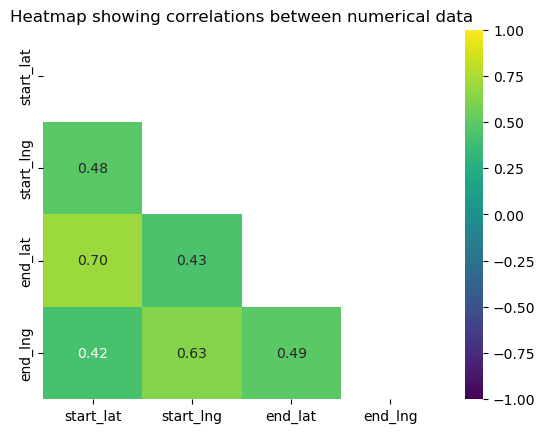

In [17]:
# Feature Importance: Correlation
sns.heatmap(
    df[numerical].corr().round(2), 
    mask=np.triu(np.ones_like(df[numerical].corr(), dtype=bool)), 
    annot=True, vmin=-1, vmax=1, cmap='viridis', fmt='.2f'
)
plt.title('Heatmap showing correlations between numerical data')
plt.show();

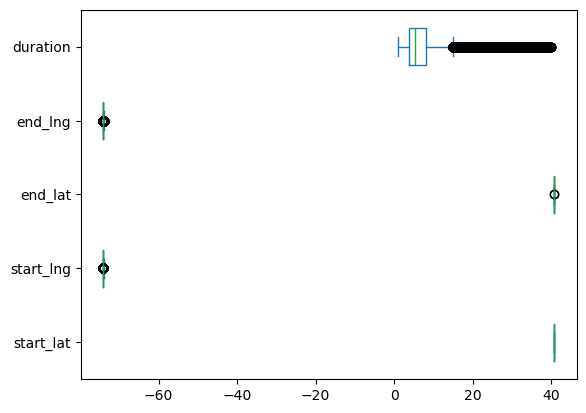

In [18]:
df.select_dtypes('number').plot(kind='box', vert=False);

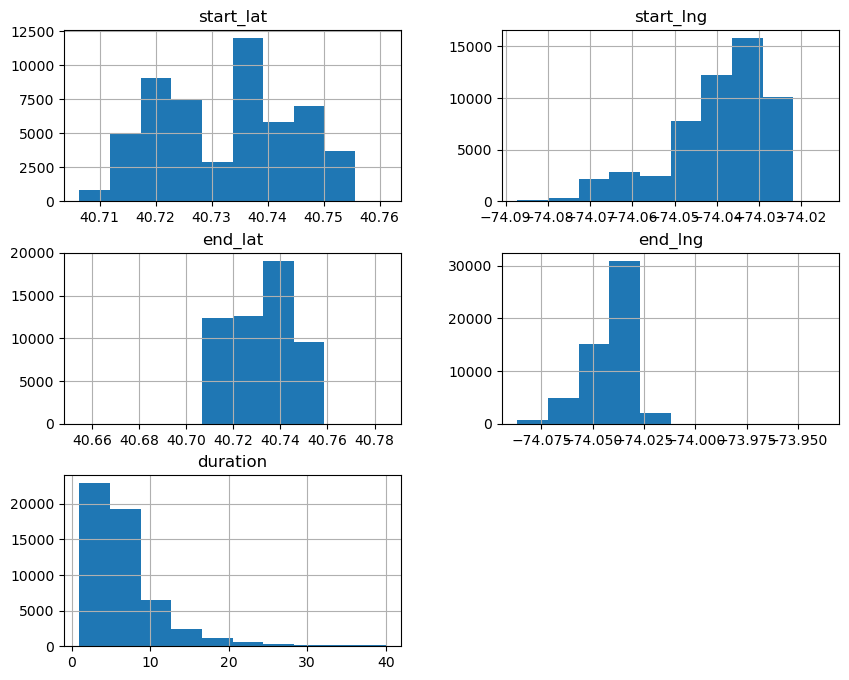

In [19]:
df.select_dtypes('number').hist(figsize=(10, 8));

## Split data into training and testing sets

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value (`class`) is not in your dataframe.

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline

## Set the random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [21]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [22]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

4.6300019762566

In [23]:
dir(dv)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_iterable_element',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_transform',
 '_validate_data',
 '_validate_params',
 'dtype',
 'feature_names_',
 'fit',
 'fit_transform',
 'get_feature_names

In [24]:
len(dv.feature_names_)

225

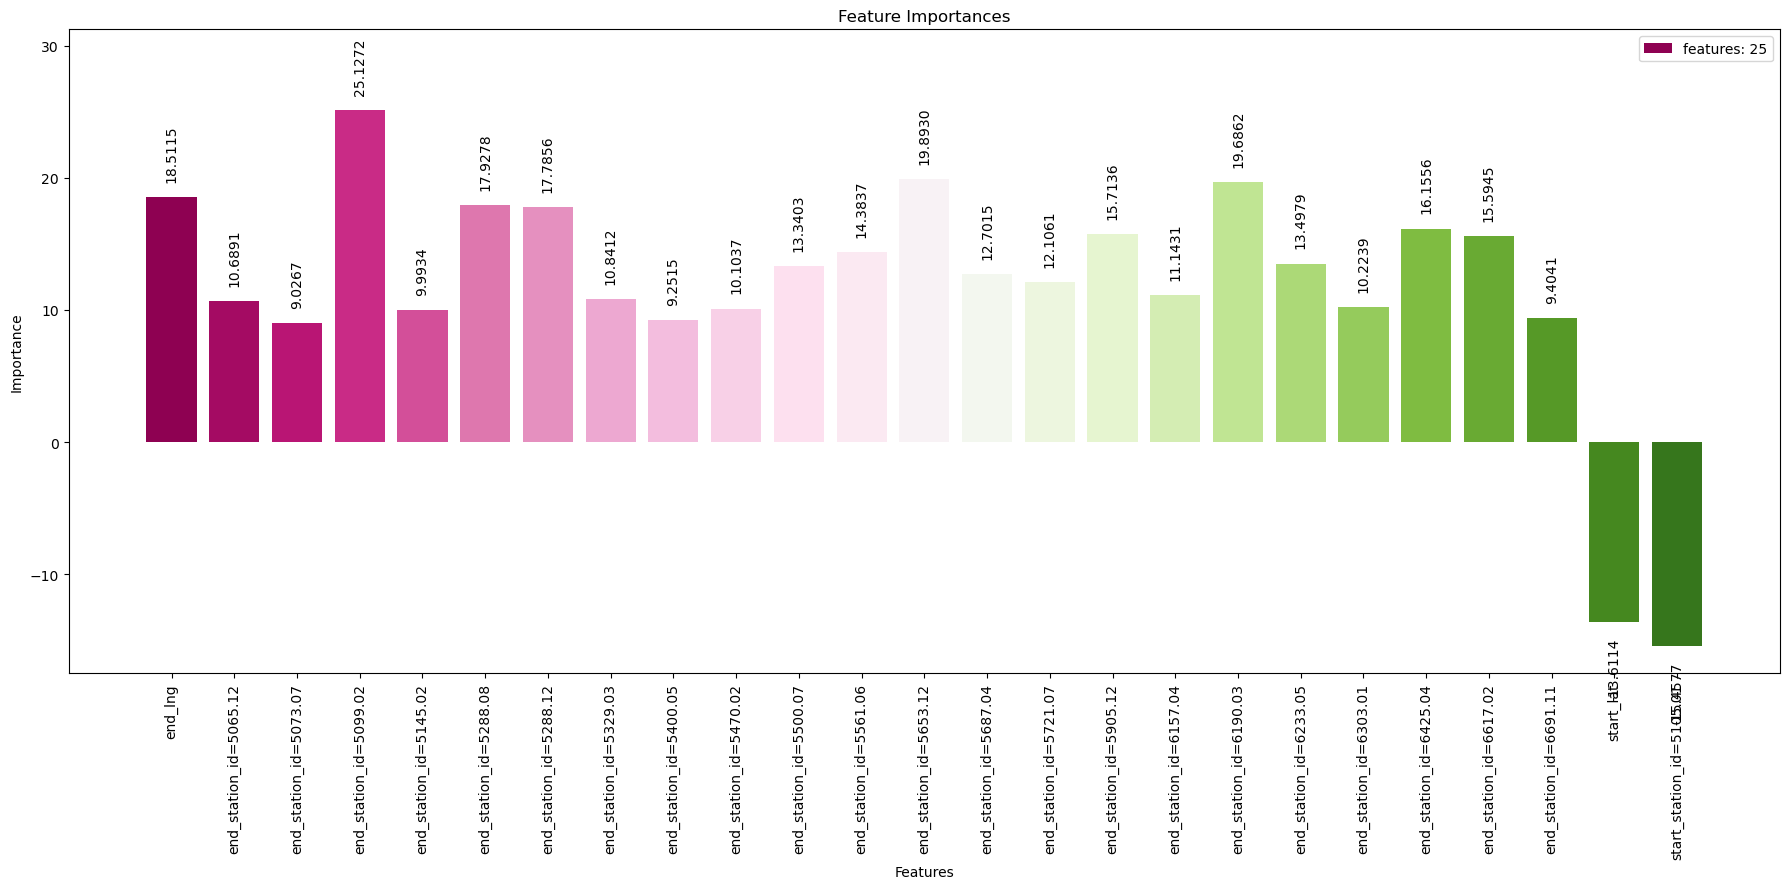

In [25]:
# The usual train-test split mumbo-jumbo
import scikitplot as skplt
skplt.estimators.plot_feature_importances(lr, figsize=(18,9),threshold=9,feature_names=dv.get_feature_names_out())
plt.show()

/tmp/ipykernel_5540/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5540/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


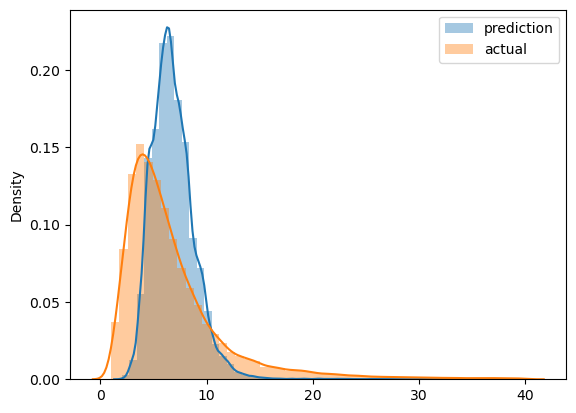

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [27]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename, sep =",")

        df.started_at = pd.to_datetime(df.started_at)
        df.ended_at = pd.to_datetime(df.ended_at)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.ended_at - df.started_at
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['rideable_type', 'member_casual', 'start_station_id','end_station_id']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [28]:
df_train = read_dataframe('./data/JC-202402-citibike-tripdata.csv')
df_val = read_dataframe('./data/JC-202403-citibike-tripdata.csv')

In [29]:
len(df_train), len(df_val)

(54039, 63353)

In [30]:
def preprocess_dataFrame(train_df):
    train_df['PU_DO'] = train_df['start_station_id'] + '_' + train_df['end_station_id']

    categorical = ['rideable_type', 'member_casual', 'start_station_id','end_station_id','PU_DO']
    numerical = ['start_lat', 'start_lng', 'end_lat', 'end_lng']
    
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return 

In [31]:
df_train['PU_DO'] = df_train['start_station_id'] + '_' + df_train['end_station_id']
df_val['PU_DO'] = df_val['start_station_id'] + '_' + df_val['end_station_id']

In [32]:
categorical = ['rideable_type', 'member_casual','PU_DO'] # PU_DO = 'PULocationID_DOLocationID'
numerical = ['start_lat', 'start_lng', 'end_lat', 'end_lng']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [33]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

# Model Training

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.128243038701022

```python
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
```

In [35]:
ls = Lasso(0.01)
ls.fit(X_train, y_train)

y_pred = ls.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.213445006100273

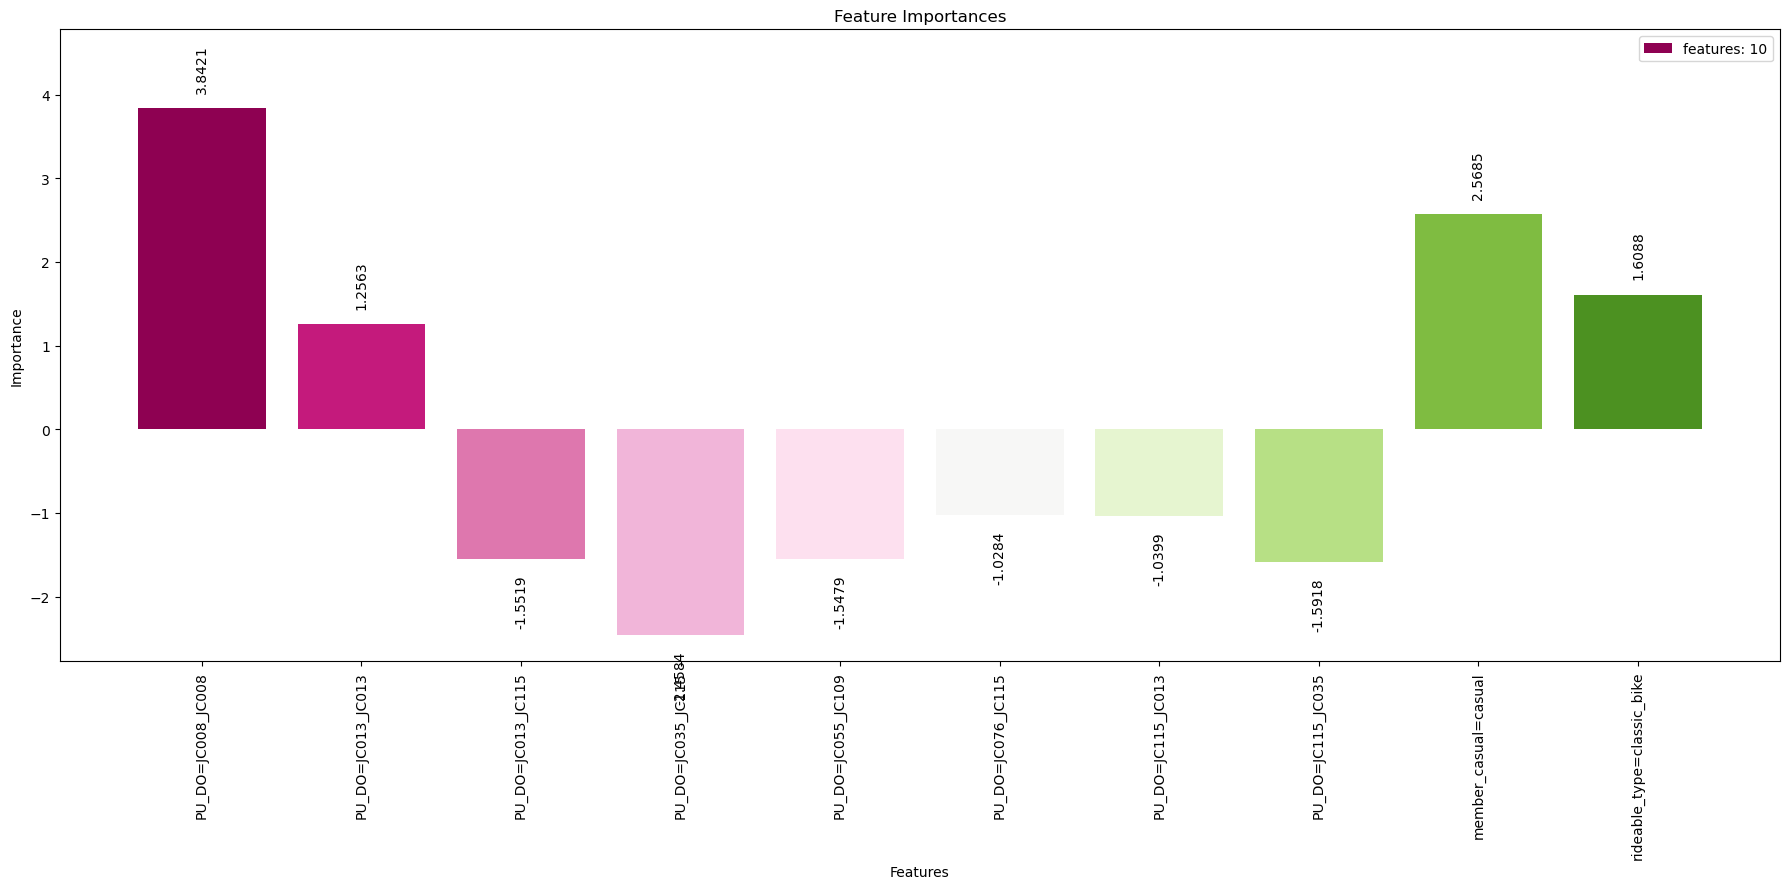

In [36]:
# The usual train-test split mumbo-jumbo
import scikitplot as skplt
skplt.estimators.plot_feature_importances(ls,figsize=(18,9),threshold=1,feature_names = dv.feature_names_)
plt.show()

In [62]:
%%writefile ./pycode/preprocess_data.py

import os
import pickle
import zipfile
import requests

from glob import glob

import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

def fetch_data(raw_data_path: str, location: str, year: int, month: int) -> None:
    """Fetches data from the NYC Citi Bike dataset and saves it locally"""
    filename = f'{location}{year}{month:0>2}-citibike-tripdata.csv.zip'
    filepath = os.path.join(raw_data_path, filename)
    url = f'https://s3.amazonaws.com/tripdata/{filename}'

    # Create the destination folder if it does not exist
    os.makedirs(raw_data_path, exist_ok=True)

    # Download the data
    response = requests.get(url)
    if response.status_code == 200:
        with open(filepath, "wb") as f_out:
            f_out.write(response.content)
    else:
        print(f"Failed to download data for {location} {year}-{month:02d}. HTTP Status Code: {response.status_code}")
        return

    # Extract the CSV file from the ZIP file
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        # Filter to get only the relevant CSV files
        csv_files = [file for file in zip_ref.namelist() if file.endswith('.csv') and not file.startswith('__MACOSX')]

        if len(csv_files) != 1:
            print(f"Unexpected file structure in {filename}. Found files: {csv_files}")
            return

        # Extract the CSV file to the specified directory
        zip_ref.extract(csv_files[0], path=raw_data_path)
        print(f"Extracted {csv_files[0]} to {raw_data_path}")

def download_data(raw_data_path: str, locations: list, years: list, months: list) -> None:
    try:
        # Download data for each combination of location, year, and month
        for loc in locations: 
            for year in years:       
                for month in months:
                    print(f"Fetching data for {loc} {year}-{month:02d}...")
                    fetch_data(raw_data_path, loc, year, month)
    except Exception as e:
        print("An error occurred during the data download process:", e)


def read_data(file_name: str)-> pd.DataFrame:
    """Read data into DataFrame"""
    df = pd.read_csv(file_name)

    # Convert Datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at']   = pd.to_datetime(df['ended_at'])

    df["duration"] = df["ended_at"]-df["started_at"]
    df["duration_minutes"] = df["duration"].dt.total_seconds()/60

    # define criteria for outliers
    lower_threshold = 1
    upper_threshold = 60

    # filter dataframe based on threshold
    df = df[
    (df["duration_minutes"]>=lower_threshold) &
    (df["duration_minutes"]<=upper_threshold)
    ]

    # Define the categorical columns
    categorical_features = [
        'start_station_id',
        'end_station_id'
    ]
    
    df[categorical_features] = df[categorical_features].astype(str)
    # print(df.shape)
    return df

def preprocess(df: pd.DataFrame, dv: DictVectorizer = None, fit_dv: bool = False):
    def haversine_distance(row):
        lat1, lon1, lat2, lon2 = row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']
        # Convert latitude and longitude from degrees to radians
        lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

        # Radius of the Earth in kilometers
        radius = 6371.0

        # Haversine formula
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = radius * c    
        return distance

    """Add features to the model"""
    # Add location ID
    df['start_to_end_station_id'] = df['start_station_id'] + '_' + df['end_station_id']
    categorical = ["start_to_end_station_id"]

    # Calc Distance
    df['trip_distance'] = df.apply(haversine_distance, axis=1).fillna(0)
    numerical   = ['trip_distance']
    dicts       = df[categorical + numerical].to_dict(orient='records')

    if fit_dv:
        # return sparse matrix
        dv = DictVectorizer()
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
        
    # Convert X the sparse matrix  to pandas DataFrame, but too slow
    # X = pd.DataFrame(X.toarray(), columns=dv.get_feature_names_out())
    # X = pd.DataFrame.sparse.from_spmatrix(X, columns=dv.get_feature_names_out())

    try:
        # Extract the target
        target = 'member_casual'
        y = df[target].values
    except Exception as e:
        print("In preprocess Something Wrong...", e)
        pass
    # print(X.shape, y.shape)
    return (X, y), dv

def dump_pickle(obj, filename: str, dest_path: str): 
    file_path = os.path.join(dest_path, filename)
       
    # Create dest_path folder unless it already exists
    os.makedirs(dest_path, exist_ok=True)
    with open(file_path, "wb") as f_out:
        return pickle.dump(obj, f_out)  


def run_data_prep(raw_data_path = "./data", dest_path= "./output",location = "JC-", years = "2024", months = "2 3 4")->None:
    # parameters
    locations = location.split(",")
    years = [int(year) for year in years.split()]
    months = [int(month) for month in months.split()]
    # print(locations, years, months)

    # download data
    print("data downloading...")
    download_data(raw_data_path, locations, years, months)
    print("data downloaded!")
    # print(sorted(glob(f'./data/*')))

    # Load csv files
    df_train = read_data(
        os.path.join(raw_data_path, f'{locations[0]}{years[0]}{months[0]:0>2}-citibike-tripdata.csv')
    )
    df_val = read_data(
        os.path.join(raw_data_path, f'{locations[0]}{years[0]}{months[1]:0>2}-citibike-tripdata.csv')
    )
    df_test = read_data(
        os.path.join(raw_data_path, f'{locations[0]}{years[0]}{months[2]:0>2}-citibike-tripdata.csv')
    )

    # Fit the DictVectorizer and preprocess data
    (X_train, y_train), dv = preprocess(df_train,fit_dv=True)
    (X_test, y_test), _ = preprocess(df_test, dv)
    (X_val, y_val), _ = preprocess(df_test, dv)

    # Save DictVectorizer and datasets
    dump_pickle(dv, "dv.pkl", dest_path)
    dump_pickle((X_train, y_train), "train.pkl",dest_path)
    dump_pickle((X_test, y_test), "test.pkl", dest_path)
    dump_pickle((X_val, y_val), "val.pkl", dest_path)

if __name__ == "__main__":
    run_data_prep()


Overwriting ./pycode/preprocess_data.py


In [63]:
!python ./pycode/preprocess_data.py

data downloading...
Fetching data for JC- 2024-02...
Extracted JC-202402-citibike-tripdata.csv to ./data
Fetching data for JC- 2024-03...
Extracted JC-202403-citibike-tripdata.csv to ./data
Fetching data for JC- 2024-04...
Extracted JC-202404-citibike-tripdata.csv to ./data
data downloaded!


In [66]:
%%writefile ./pycode/train.py

import os
import click
import pickle
# from typing import Any

import numpy as np
import scipy

# import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import mlflow

import warnings
# Ignore all warnings
# warnings.filterwarnings("ignore")
# Filter the specific warning message, MLflow autologging encountered a warning
# warnings.filterwarnings("ignore", category=UserWarning, module="setuptools")
warnings.filterwarnings("ignore", category=UserWarning, message="Setuptools is replacing distutils.")

def load_pickle(file_name: str, data_path: str) ->tuple(
    [   
        scipy.sparse._csr.csr_matrix,
        np.ndarray]
    ):
    file_path= os.path.join(data_path, file_name)
    with open (file_path, "rb") as f_in:
        return pickle.load(f_in)
    
def run_train(data_path = "./output", model_path = "./model")->None:
    """The main training pipeline""" 
    # Load train and test Data
    X_train, y_train = load_pickle("train.pkl", data_path)
    X_val, y_val     = load_pickle("val.pkl", data_path)
    # print(type(X_train), type(y_train))

    #MLflow settings
    # build or connect offline database
    mlflow.set_tracking_uri("sqlite:///mlflow.db")

    # Connect Database Online
    # mlflow.set_tracking_uri("http://127.0.0.1:5000")

    # Create a new MLflow Experiment
    # mlflow.set_experiment("MLflow-experiment")

     # Build or Connect mlflow experiment
    EXPERIMENT_NAME = "random-forest-train"
    mlflow.set_experiment(EXPERIMENT_NAME)

    # before your training code to enable automatic logging of sklearn metrics, params, and models
    # mlflow.sklearn.autolog()  

    with mlflow.start_run():
        # Optional: Set some information about Model
        mlflow.set_tag("developer", "shc")
        mlflow.set_tag("algorithm", "Machine Learning")
        mlflow.set_tag("train-data-path", f'{data_path}/train.pkl')
        mlflow.set_tag("valid-data-path", f'{data_path}/val.pkl')
        mlflow.set_tag("test-data-path",  f'{data_path}/test.pkl')        
        
        # Set Model params information
        params = {"max_depth": 9, "class_weight": "balanced", "random_state": 42}
        mlflow.log_params(params)
        
        # Build Model        
        rf     = RandomForestClassifier(**params)
        rf.fit(X_train, y_train)
        
        # autolog_run = mlflow.last_active_run()

        # Log the validation Metric to the tracking server
        y_pred = rf.predict(X_val)
        print(classification_report(y_val, y_pred))

        pr_fscore   = precision_recall_fscore_support(y_val, y_pred, average='weighted')
        # Extract the F1-score from the tuple
        weighted_f1_score = pr_fscore[2]
        mlflow.log_metric("weighted_f1_score", weighted_f1_score)
        # print("weighted_f1_score", weighted_f1_score)
                        
        # Log Model two options
        # Option1: Just only model in log
        mlflow.sklearn.log_model(sk_model = rf, artifact_path = "model_mlflow")
                
        # Option 2: save Model, and Optional: Preprocessor or Pipeline in log
        # Create model_path folder unless it already exists
        # pathlib.Path(model_path).mkdir(exist_ok=True)
        os.makedirs(model_path, exist_ok=True)
        local_path = os.path.join(model_path, "ride_duration_rf_model.pkl")
        with open(local_path, 'wb') as f_out:
            pickle.dump(rf, f_out)
            
        # whole proccess like pickle, saved Model, Optional: Preprocessor or Pipeline
        mlflow.log_artifact(local_path = local_path, artifact_path="model_pickle")        
        
        print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
    return None


if __name__ == '__main__':
    run_train()

Overwriting ./pycode/train.py


In [67]:
!python ./pycode/train.py

              precision    recall  f1-score   support

      casual       0.29      0.67      0.41     17919
      member       0.83      0.50      0.63     58493

    accuracy                           0.54     76412
   macro avg       0.56      0.59      0.52     76412
weighted avg       0.71      0.54      0.58     76412

default artifacts URI: '/home/jovyan/work/Mlops-zc/m7-project/mlruns/1/c8673c4469ce4db3b998ac9f971a16f2/artifacts'


In [ ]:
# mlflow ui  --backend-store-uri sqlite:///./mlflow.db --host localhost --port 5000

# hpo.py

In [82]:
%%writefile ./pycode/hpo.py

import os
import pickle
import click
# from typing import Any

import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import optuna
from optuna.samplers import TPESampler

import mlflow

def load_pickle(filename: str, data_path: str)->tuple(
    [
        scipy.sparse._csr.csr_matrix,
        np.ndarray
    ]
):
    file_path = os.path.join(data_path, filename)
    with open(file_path, "rb") as f_in:
        return pickle.load(f_in)

def run_optimization(data_path = "./output", num_trials = 10)-> None:
    """The main optimization pipeline"""
    # Load train and test Data

    X_train, y_train = load_pickle("train.pkl", data_path)
    X_val, y_val     = load_pickle("val.pkl", data_path) 
    # print(type(X_train), type(y_train))

    # MLflow settings
    # Build or Connect Database Offline
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    # Connect Database Online
    # mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Build or Connect mlflow experiment
    HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
    mlflow.set_experiment(HPO_EXPERIMENT_NAME)

     # before your training code to disable automatic logging of sklearn metrics, params, and models
    mlflow.sklearn.autolog(disable=True)

    # Optional: Set some information about Model
    mlflow.set_tag("developer", "shc")
    mlflow.set_tag("algorithm", "Machine Learning")
    mlflow.set_tag("train-data-path", f'{data_path}/train.pkl')
    mlflow.set_tag("valid-data-path", f'{data_path}/val.pkl')
    mlflow.set_tag("test-data-path",  f'{data_path}/test.pkl')

    def objective(trial):
        with mlflow.start_run(nested=True):
            # define  params
            params = {
                'class_weight'     : trial.suggest_categorical(name = 'class_weight', choices = ["balanced"]),
                'n_estimators'     : trial.suggest_int('n_estimators',70,120,step=10),
                'max_depth'        : trial.suggest_int('max_depth', 3, 21, step=2),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 17,step= 3),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 6, step=1),
                'random_state'     : 42,
                'n_jobs'           : -1
            }
             # Log the model params to the tracking server
            mlflow.log_params(params)

            # Build Model   
            rf = RandomForestClassifier(**params)
            rf.fit(X_train, y_train)
            
            # Log the validation Metric to the tracking server
            y_pred_val = rf.predict(X_val)
            # print(classification_report(y_val, y_pred))

            pr_fscore_val   = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')
            # Extract the F1-score from the tuple
            weighted_f1_score_val = pr_fscore_val[2]
            mlflow.log_metric("weighted_f1_score_val", weighted_f1_score_val)
            # print("weighted_f1_score_val", weighted_f1_score_val)
        return weighted_f1_score_val

    sampler = TPESampler(seed=42)
    study   = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(func = objective, n_trials=num_trials, n_jobs=-1)
    
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
    return None


if __name__ == '__main__':
    run_optimization()

Overwriting ./pycode/hpo.py


In [83]:
!python ./pycode/hpo.py

[I 2024-08-24 17:33:15,677] A new study created in memory with name: no-name-89057303-e22d-44e7-9b02-b57c5a581b19
[I 2024-08-24 17:33:20,896] Trial 2 finished with value: 0.5702930883673479 and parameters: {'class_weight': 'balanced', 'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.5702930883673479.
[I 2024-08-24 17:33:21,817] Trial 7 finished with value: 0.574228956307057 and parameters: {'class_weight': 'balanced', 'n_estimators': 80, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.574228956307057.
[I 2024-08-24 17:33:24,694] Trial 5 finished with value: 0.570446289040532 and parameters: {'class_weight': 'balanced', 'n_estimators': 80, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.574228956307057.
[I 2024-08-24 17:33:24,832] Trial 1 finished with value: 0.577746717664759 and parameters: {'class_weight': 'balanced', 'n_estima

# register_model.py

In [84]:
%%writefile ./pycode/register_model.py

import os
import click
import pickle
# from typing import Any

import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

import warnings
# Ignore all warnings
# warnings.filterwarnings("ignore")
# Filter the specific warning message, MLflow autologging encountered a warning
# warnings.filterwarnings("ignore", category=UserWarning, module="setuptools")
warnings.filterwarnings("ignore", category=UserWarning, message="Setuptools is replacing distutils.")
warnings.filterwarnings("ignore", category=UserWarning, message="Distutils was imported before Setuptools,*")


def load_pickle(
    filename: str, data_path: str
) -> tuple(
    [
        scipy.sparse._csr.csr_matrix,
        np.ndarray
    ]
):
    file_path = os.path.join(data_path, filename)
    with open(file_path, "rb") as f_in:
        return pickle.load(f_in)


def train_and_log_model(data_path, params, experiment_name): 
    """The main training pipeline"""    
    # Load train, val and test Data
    X_train, y_train = load_pickle("train.pkl", data_path)
    X_val, y_val     = load_pickle("val.pkl", data_path)
    X_test, y_test   = load_pickle("test.pkl", data_path)
    # print(type(X_train), type(y_train))
    
    # MLflow settings
    # Build or Connect Database Offline
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    # Connect Database Online
    # mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Build or Connect mlflow experiment
    EXPERIMENT_NAME = experiment_name
    mlflow.set_experiment(EXPERIMENT_NAME)
    
    # before your training code to enable automatic logging of sklearn metrics, params, and models
    # mlflow.sklearn.autolog()

    with mlflow.start_run(nested=True):
        # Optional: Set some information about Model
        mlflow.set_tag("developer", "shc")
        mlflow.set_tag("algorithm", "Machine Learning")
        mlflow.set_tag("train-data-path", f'{data_path}/train.pkl')
        mlflow.set_tag("valid-data-path", f'{data_path}/val.pkl')
        mlflow.set_tag("test-data-path",  f'{data_path}/test.pkl')  

        # Set Model params information
        RF_PARAMS = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'random_state', 'n_jobs']
        for param in RF_PARAMS:
            params[param] = int(params[param])
            
        # Log the model params to the tracking server
        mlflow.log_params(params)

        # Build Model
        rf = RandomForestClassifier(**params)
        rf.fit(X_train, y_train)

        # Log the validation and test Metric to the tracking server
        y_pred_val = rf.predict(X_val)
        y_pred_test = rf.predict(X_test)
        pr_fscore_val   = precision_recall_fscore_support(y_val, y_pred_val, average='weighted')
        pr_fscore_test   = precision_recall_fscore_support(y_test, y_pred_test, average='weighted')
        # Extract the F1-score from the tuple
        weighted_f1_score_val = pr_fscore_val[2]
        weighted_f1_score_test = pr_fscore_test[2]
        mlflow.log_metric("weighted_f1_score_val", weighted_f1_score_val)
        mlflow.log_metric("weighted_f1_score_test", weighted_f1_score_test)
        # print("weighted_f1_score_val", weighted_f1_score_val)

        # Log the model
        # Option1: Just only model in log
        mlflow.sklearn.log_model(sk_model = rf, artifact_path = "model_mlflow")
        
        # print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")
    return None


def run_register_model(data_path="./output", top_n=5) -> None:
    """The main optimization pipeline"""
    # Parameters
    EXPERIMENT_NAME = "random-forest-best-models"
    HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
    client = MlflowClient("sqlite:///mlflow.db")

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.weighted_f1_score_val DESC"]
    )
    for run in runs:
        train_and_log_model(data_path=data_path, params=run.data.params, experiment_name=EXPERIMENT_NAME)

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.weighted_f1_score_test DESC"]
    )[0]

    # Register the best model
    run_id     = best_run.info.run_id
    model_uri  = f"runs:/{run_id}/model"
    model_name = "rf-best-model"
    mlflow.register_model(model_uri, name=model_name)

    # print("Test weighted_f1_score_test of the best model: {:.4f}".format(best_run.data.metrics["weighted_f1_score_test"]))
    return None


if __name__ == '__main__':
    run_register_model()

Writing ./pycode/register_model.py


In [85]:
!python ./pycode/register_model.py

2024/08/24 18:05:31 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-best-models' does not exist. Creating a new experiment.
Successfully registered model 'rf-best-model'.
Created version '1' of model 'rf-best-model'.


# End of The Project: Part 2

In [89]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.sparse import hstack
from scipy.stats import stats

from sklearn.feature_extraction import DictVectorizer
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
# from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import os
import sys
import pickle
import zipfile
# import boto3
# import click
# import pathlib
# import argparse
# import requests
# import urllib.request
from glob import glob
# from tqdm import tqdm           # console-based
# from tqdm.notebook import tqdm  # jupyter-based
from tqdm.auto import tqdm        # automatically selects
# tqdm._instances.clear()

import mlflow
import wandb

# import prefect
# from prefect import task, flow, Flow
# from prefect.tasks import task_input_hash
# from prefect.artifacts import create_markdown_artifact

# memory management performs garbage collection 
import gc
gc.collect()

2314

In [90]:
# from mlflow.tracking import MlflowClient
# from mlflow.exceptions import MlflowException
import mlflow; print("mlflow.__version__: ", mlflow.__version__)
import wandb;  print("wandb.__version__ : ", wandb.__version__)

mlflow.__version__:  2.14.2
wandb.__version__ :  0.17.7


In [91]:
!prefect version

Traceback (most recent call last):
  File "/opt/conda/bin/prefect", line 5, in <module>
    from prefect.cli import app
  File "/opt/conda/lib/python3.11/site-packages/prefect/__init__.py", line 30, in <module>
    from prefect.deployments import deploy
  File "/opt/conda/lib/python3.11/site-packages/prefect/deployments/__init__.py", line 1, in <module>
    import prefect.deployments.base
  File "/opt/conda/lib/python3.11/site-packages/prefect/deployments/base.py", line 22, in <module>
    from prefect.client.schemas.objects import MinimalDeploymentSchedule
  File "/opt/conda/lib/python3.11/site-packages/prefect/client/schemas/__init__.py", line 4, in <module>
    from .actions import BlockTypeUpdate, StateCreate
  File "/opt/conda/lib/python3.11/site-packages/prefect/client/schemas/actions.py", line 15, in <module>
    import prefect.client.schemas.objects as objects
  File "/opt/conda/lib/python3.11/site-packages/prefect/client/schemas/objects.py", line 49, in <module>
    from prefe

In [92]:
import os
# Get the current working directory
# current_dir = os.getcwd()

# Create a new directory for storing data
os.makedirs('./pycode', exist_ok=True)
# os.makedirs('./data', exist_ok=True)
# os.makedirs('./output', exist_ok=True)
# os.makedirs('./model', exist_ok=True)

# orchestrate.py

In [ ]:
%%writefile ./pycode/orchestrate.py

import os
import pickle
import zipfile

# import pathlib
import requests
import urllib.request
from glob import glob
from datetime import date
from datetime import timedelta

import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import mlflow
import prefect
from prefect import task, flow
from prefect.tasks import task_input_hash
from prefect.artifacts import create_markdown_artifact

# from prefect_aws import S3Bucket
# from prefect_email import EmailServerCredentials, email_send_message

import warnings
# Ignore all warnings
# warnings.filterwarnings("ignore")
# Filter the specific warning message, MLflow autologging encountered a warning
# warnings.filterwarnings("ignore", category=UserWarning, module="setuptools")
warnings.filterwarnings("ignore", category=UserWarning, message="Setuptools is replacing distutils.")


